# Imputing Missing Data

Les données manquantes font référence à l'absence de valeurs pour certaines observations et constituent un problème inévitable dans la plupart des sources de données. Scikit-learn ne prend pas en charge les valeurs manquantes en entrée, nous devions donc supprimer les observations avec des données manquantes ou les transformer en valeurs autorisées. Le faite de remplacer les données manquantes par des estimations statistiques est appelé imputation. L'objectif de toute technique d'imputation est de produire un ensemble de données complet qui peut être utilisé pour former des modèles d'apprentissage automatique. Il existe plusieurs techniques d'imputation que nous pouvons appliquer à nos données. Le choix de la technique d'imputation que nous utilisons dépendra du fait que les données manquent soit hasard, et du nombre de valeurs manquantes et du modèle d'apprentissage automatique que nous avons l'intention d'utiliser. Dans cet article, nous discuterons de plusieurs techniques d'imputation des données manquantes.

Cet article couvrira les points suivants :

* Suppression des observations contenant des données manquantes
* Effectuer une imputation moyenne ou médiane
* imputation par mode ou par catégorie fréquente
* Remplacer les valeurs manquantes par un nombre arbitraire
* Imputation par catégorie manquante
* Ajout d'une variable indicatrice manquante
* Effectuer une imputation multivariée avec MICE, KNN ou Random Forests
* Assembler un pipeline d'imputation avec scikit-learn

Dans cet article, nous utiliserons les librairies Python : pandas, NumPy et scikit-learn

Nous utiliserons également l'ensemble de données d'approbation de crédit, qui est disponible dans le référentiel UCI MachineLearning (https://archive.ics.uci.edu/ml/datasets/credit+approval)

Pour préparer l'ensemble de données, procédez comme suit :

In [1]:
#Importez les bibliothèques Python requises :
import random
import pandas as pd
import numpy as np

In [2]:
#Chargez les données avec la commande suivante
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data', header=None)

In [3]:
#Créez une liste avec des noms de variables :
varnames = ['A'+str(s) for s in range(1,17)]

In [4]:
#Ajoutez les noms de variables au dataframe :
data.columns = varnames

In [5]:
#Remplacez les points d'interrogation (?) dans l'ensemble de données par les valeurs NumPy NaN
data = data.replace('?', np.nan)

In [6]:
#changer le type des variables numériques en types de données flottants :
data['A2'] = data['A2'].astype('float')
data['A14'] = data['A14'].astype('float')

In [7]:
#Recoder la variable cible en binaire :
data['A16'] = data['A16'].map({'+':1, '-':0})

In [8]:
#Ajoutez des valeurs manquantes à des positions aléatoires dans quatre variables :
random.seed(9001)
values = set([random.randint(0, len(data)) for p in range(0, 100)])
for var in ['A3', 'A8', 'A9', 'A10']:
  data.loc[values, var] = np.nan

##Suppression des observations avec des données manquantes
L'analyse complète de cas (CCA)(Complete Case Analysis) , consiste à rejeter les observations pour lesquelles les valeurs de l'une des variables sont manquantes. L'ACC peut être appliquée aux variables catégorielles et numériques. L'ACC est rapide et facile à mettre en œuvre et a l'avantage de préserver la distribution des variables, à condition que les données soient manquantes au hasard et que seule une petite proportion des données manque. Cependant, si des données sont manquantes pour de nombreuses variables, la CCA peut entraîner la suppression d'une grande partie de l'ensemble de données.

### Comment faire...

In [9]:
#Calculons le pourcentage de valeurs manquantes pour chaque variable et trions-les par ordre croissant :
data.isnull().mean().sort_values(ascending=True)

A11    0.000000
A12    0.000000
A13    0.000000
A15    0.000000
A16    0.000000
A4     0.008696
A5     0.008696
A6     0.013043
A7     0.013043
A1     0.017391
A2     0.017391
A14    0.018841
A3     0.133333
A8     0.133333
A9     0.133333
A10    0.133333
dtype: float64

In [10]:
#Maintenant, nous allons supprimer les observations avec des données manquantes dans toute les variables :
data_cca = data.dropna()

Pour supprimer des observations où des données sont manquantes dans un sous-ensemble de variables, nous pouvons exécuter data.dropna(subset=['A3', 'A4']). Pour supprimer les observations si des données sont manquantes dans toutes les variables, nous pouvons exécuterata.dropna(how='all')

In [11]:
#comparons la taille des ensembles de données de cas d'origine et complet :
print('Number of total observations: {}'.format(len(data)))
print('Number of observations with complete cases:{}'.format(len(data_cca)))
#Ici, nous avons supprimé plus de 100 observations avec des données manquantes, comme indiqué dans la sortie suivante

Number of total observations: 690
Number of observations with complete cases:564


## Effectuer une imputation moyenne ou médiane
L'imputation moyenne ou médiane consiste à remplacer les valeurs manquantes par la variable moyenne ou médiane. Ceci ne peut être effectué que dans des variables numériques. La moyenne ou la médiane est calculée à l'aide d'un ensemble d'apprentissage, et ces valeurs sont utilisées pour imputer les données manquantes dans les ensembles d'apprentissage et de test, ainsi que dans les données futures que nous avons l'intention de scorer avec le modèle d'apprentissage automatique. Par conséquent, nous devons stocker ces valeurs moyennes et médianes. Les transformateurs Scikit-learn apprennent les paramètres sur l'ensemble d'apprentissage et stockent ces paramètres pour une utilisation future. Ainsi, dans cette recette, nous allons apprendre à effectuer une imputation moyenne ou médiane à l'aide des bibliothèques et pandas thescikit-learn.

Remarque : Utiliser l'imputation moyenne si les variables sont distribuées normalement et l'imputation médiane sinon. L'imputation moyenne et médiane peut fausser la distribution des variables d'origine s'il y a un pourcentage élevé de données manquantes

Comment faire... :

In [12]:
#Tout d'abord, nous allons importer les pandas et les fonctions et classes requises depuis scikit-learn :
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

Dans l'imputation moyenne et médiane, les valeurs moyennes ou médianes doivent être calculées à l'aide des variables de l'ensemble d'apprentissage ; Par conséquent, séparons les données en ensembles d'apprentissage et de test et leurs cibles respectives

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

In [14]:
#Vérifions le pourcentage de valeurs manquantes dans l'ensemble d'apprentissage :
print(X_train.isnull().mean())
#La sortie suivante affiche le pourcentage de valeurs manquantes pour chaque variable :

A1     0.008282
A2     0.022774
A3     0.140787
A4     0.008282
A5     0.008282
A6     0.008282
A7     0.008282
A8     0.140787
A9     0.140787
A10    0.140787
A11    0.000000
A12    0.000000
A13    0.000000
A14    0.014493
A15    0.000000
dtype: float64


### Mean / median imputation with pandas

In [15]:
#Remplacez les valeurs manquantes par la médiane des cinq variables numériques. en utilisant des pandas :
for var in ['A2', 'A3', 'A8', 'A11', 'A15']:
  value = X_train[var].median()
  X_train[var] = X_train[var].fillna(value)
  X_test[var] = X_test[var].fillna(value)


Remarque: 
Le fillna() des pandas renvoie un nouvel ensemble de données avec des valeurs imputées par défaut. Nous pouvons définir l'argument inplace sur True pour remplacer les données manquantes dans le cadre de données d'origine : X_train[var].fillna(inplace=True)

### Mean / median imputation with Scikit-learn

Maintenant, imputons les valeurs manquantes par la médiane à l'aide de scikit-learn afin que nous puissions stocker les paramètres appris

In [16]:
#Pour ce faire, séparons l'ensemble de données d'origine en ensembles d'apprentissage et de test, en ne conservant que les variables numériques :
X_train, X_test, y_train, y_test = train_test_split(data[['A2', 'A3', 'A8', 'A11', 'A15']], data['A16'], test_size=0.3, random_state=0)

SimpleImputer() de scikit-learn imputera toutes les variables de l'ensemble de données. Par conséquent, si nous utilisons une imputation moyenne ou médiane et que l'ensemble de données contient des variables catégorielles, nous obtiendrons une erreur

In [17]:
#Créons un transformateur d'imputation médian à l'aide de SimpleImputer() de scikit-learn :
imputer = SimpleImputer(strategy='median')
#Pour effectuer une imputation moyenne, nous devons définir la stratégie sur Mean:
#imputer = SimpleImputer(strategy = 'mean')

In [18]:
# fit le SimpleImputer() au train set afin qu'il apprenne les valeurs médianes des variables :
imputer.fit(X_train)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [19]:
#Inspectons les valeurs médianes apprises :
imputer.statistics_

array([28.835,  2.75 ,  1.   ,  0.   ,  6.   ])

In [20]:
#Remplaçons les valeurs manquantes par des médianes :
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

### Mean / median imputation with Sklearn selecting features to impute

In [21]:
import pandas as pd

# to impute missing data with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the data sets
from sklearn.model_selection import train_test_split

In [22]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

In [23]:

# first we need to make a list with the numerical vars
numeric_features_mean = ['A2', 'A3', 'A8', 'A11', 'A15']

# then we instantiate the imputer within a pipeline
numeric_mean_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

# then we put the features list and the imputer in the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('mean_imputer', numeric_mean_imputer, numeric_features_mean)
    ], remainder='passthrough')

In [24]:

# now we fit the preprocessor
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('mean_imputer',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='mean',
                                                                verbose=0))],
                                          verbose=False),
                                 ['A2', 'A3', 'A8', 'A11', 'A15'])],
                  verbose=False)

In [25]:

# and now we impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [26]:
# Note that Scikit-Learn transformers return NumPy arrays!!
X_train

array([[46.08, 3.0, 2.375, ..., 't', 'g', 396.0],
       [15.92, 2.875, 0.085, ..., 'f', 'g', 120.0],
       [36.33, 2.125, 0.085, ..., 'f', 'g', 50.0],
       ...,
       [19.58, 0.665, 1.665, ..., 'f', 'g', 220.0],
       [22.83, 2.29, 2.29, ..., 't', 'g', 140.0],
       [40.58, 3.29, 3.5, ..., 't', 's', 400.0]], dtype=object)

## Imputation par mode ou par catégorie fréquente

L'imputation modale consiste à remplacer les valeurs manquantes par le mode. Nous utilisons normalement cette procédure dans les variables catégorielles, d'où le nom  d'imputation de catégorie fréquente. Les catégories fréquentes sont estimées à l'aide de l'ensemble de train, puis utilisées pour imputer des valeurs dans les ensembles de données train, test et futurs. Ainsi, nous devons apprendre et stocker ces paramètres.

Comment faire...


In [27]:
#Importons pandas et les fonctions et classes requises depuis scikit-learn :
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [28]:
#Les catégories fréquentes doivent être calculées à l'aide des variables d'ensemble d'apprentissage, séparons donc les données en ensembles d'apprentissage et de test et leurs cibles respectives :
X_train, X_test, y_train, y_test = train_test_split(data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

### Frequent category imputation with pandas

In [29]:
#Remplaçons les valeurs manquantes par la catégorie fréquente, c'est-à-dire le mode, pour les quatres variables catégorielles
for var in ['A4', 'A5', 'A6', 'A7']:
  value = X_train[var].mode()[0]
  X_train[var] = X_train[var].fillna(value)
  X_test[var] = X_test[var].fillna(value)

### Frequent category imputation with Scikit-learn
Maintenant, imputons les valeurs manquantes par la catégorie la plus fréquente en utilisant scikit-learn

In [30]:
#Tout d'abord, séparons l'ensemble de données d'origine en ensembles d'apprentissage et de test et ne conservons que les variables catégorielles
X_train, X_test, y_train, y_test = train_test_split(
    data[['A4', 'A5', 'A6', 'A7']], data['A16'], test_size=0.3, random_state=0)

In [31]:
# créer un objet d'imputation de catégorie fréquente avec SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# fit de  l'imputeur sur l'ensembme d'apprentissage pour qu'il apprenne les valeurs les plus fréquentes :
imputer.fit(X_train)

# on peut regarder les modes appris :
imputer.statistics_

array(['u', 'g', 'c', 'v'], dtype=object)

In [32]:
# Remplaçons les valeurs manquantes par des catégories fréquentes

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

## Remplacer les valeurs manquantes par un nombre arbitraire

L'imputation par un nombre arbitraire consiste à remplacer les valeurs manquantes par une valeur arbitraire. Certaines valeurs couramment utilisées incluent 999, 9999 ou -1 pour les distributions positives. Cette méthode convient aux variables numériques.

Lors du remplacement des valeurs manquantes par un nombre arbitraire, nous devons faire attention à ne pas sélectionner une valeur proche de la moyenne ou de la médiane, ou toute autre valeur commune de la distribution.

Remarque:
   L'imputation par nombres arbitraire peut être utilisée lorsque les données manquentes ne sont pas de manière aléatoire, lorsque nous construisons des modèles non linéaires et lorsque le pourcentage de données manquantes est élevé. Cette technique d'imputation fausse la distribution des variables d'origine

In [33]:
#Importez des pandas et les fonctions et classes requises depuis scikit-learn
import pandas as pd

# to split the data sets
from sklearn.model_selection import train_test_split

# to impute missing data with sklearn
from sklearn.impute import SimpleImputer

In [34]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

### Arbitrary imputation with pandas

In [35]:
# Trouvez la valeur maximale pour quatres variables numériques :
X_train[['A2','A3', 'A8', 'A11']].max()

A2     76.750
A3     26.335
A8     20.000
A11    67.000
dtype: float64

In [36]:
# Remplaçons les valeurs manquantes par 99 dans les variables numériques que nous avons spécifiées
for var in ['A2','A3', 'A8', 'A11']:
    X_train[var].fillna(99, inplace=True)
    X_test[var].fillna(99, inplace=True)

Nous avons choisi 99 comme valeur arbitraire car elle est supérieure à la valeur maximale de ces variables

### Arbitrary imputation with Scikit-learn

In [37]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[['A2', 'A3', 'A8', 'A11']],
    data['A16'],
    test_size=0.3,
    random_state=0)

In [38]:

# create an instance of the simple imputer
imputer = SimpleImputer(strategy='constant', fill_value=99)

# we fit the imputer to the train set
imputer.fit(X_train)

# we can look at the constant values:
imputer.statistics_

array([99., 99., 99., 99.])

Si votre ensemble de données contient des variables catégorielles, SimpleImputer() ajoutera 99 à ces variables également si des valeurs sont manquantes

In [39]:
# and now we impute the train and test set
# NOTE: the data is returned as a numpy array!!!

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

### Arbitrary imputation imputation with Sklearn selecting features to impute

In [40]:
import pandas as pd

# to impute missing data with sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# to split the data sets
from sklearn.model_selection import train_test_split

In [41]:
# let's separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1),data['A16' ], test_size=0.3, random_state=0)

In [42]:
# first we need to make a list with the numerical vars
features_arbitrary = ['A2', 'A3', 'A8', 'A11']
features_mean = ['A15']

# then we instantiate the imputer within a pipeline
arbitrary_imputer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=99))])

mean_imputer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])

# then we put the features list and the imputer in
# the column transformer
preprocessor = ColumnTransformer(transformers=[
    ('arbitrary_imputer', arbitrary_imputer, features_arbitrary),
    ('mean_imputer', mean_imputer, features_mean)
    ], remainder='passthrough')

In [43]:

# now we fit the preprocessor
preprocessor.fit(X_train)

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('arbitrary_imputer',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=99,
                                                                missing_values=nan,
                                                                strategy='constant',
                                                                verbose=0))],
                                          verbose=False),
                                 ['A2', 'A3', 'A8', 'A11']),
                                ('mean_imputer',
                                 Pipeline(memory=None,

In [44]:
# and now we impute the data
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [45]:
# Note that Scikit-Learn transformers return NumPy arrays!!
X_train

array([[46.08, 3.0, 2.375, ..., 't', 'g', 396.0],
       [15.92, 2.875, 0.085, ..., 'f', 'g', 120.0],
       [36.33, 2.125, 0.085, ..., 'f', 'g', 50.0],
       ...,
       [19.58, 0.665, 1.665, ..., 'f', 'g', 220.0],
       [22.83, 2.29, 2.29, ..., 't', 'g', 140.0],
       [40.58, 3.29, 3.5, ..., 't', 's', 400.0]], dtype=object)

### Imputation par catégorie manquante
Les données manquantes dans les variables catégorielles peuvent être traitées comme une catégorie différente. Dans cette recette, nous allons créer une catégorie « Manquante » pour remplacer les valeurs manquantes dans les variables catégorielles à l'aide de pandas, Scikit-learn. 

### Ajouter une catégorie avec des pandas

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

In [47]:
# replace NA in some categorical variables

for var in ['A4', 'A5', 'A6', 'A7']:

    X_train[var].fillna('Missing', inplace=True)
    X_test[var].fillna('Missing', inplace=True)

In [48]:
# check absence of missing values
X_train[['A4', 'A5', 'A6', 'A7']].isnull().sum()

A4    0
A5    0
A6    0
A7    0
dtype: int64

### Ajouter une catégorie 'Missing' avec Sklearn

In [49]:
# let's separate into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    data[['A4', 'A5', 'A6', 'A7']], data['A16'], test_size=0.3, random_state=0)


In [50]:
# create an instance of the simple imputer
imputer = SimpleImputer(strategy='constant', fill_value='Missing')

# we fit the imputer to the train set
imputer.fit(X_train)

# we can look at the new category:
imputer.statistics_

array(['Missing', 'Missing', 'Missing', 'Missing'], dtype=object)

SimpleImputer() de scikit-learn remplacera les valeurs manquantes par Missing dans les variables numériques et catégorielles. Faites attention à ce comportement ou vous finirez par convertir accidentellement vos variables numériques en objets


In [51]:

# and now we impute the train and test set
# NOTE: the data is returned as a numpy array!!!

X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)

In [52]:

pd.DataFrame(X_train).isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

## Ajout d'une variable indicatrice manquante

Un indicateur manquant est une variable binaire qui spécifie si une valeur manquait pour une observation (1) ou non (0). Il est courant de remplacer les observations manquantes par la moyenne, la médiane ou le mode tout en marquant ces observations manquantes avec un indicateur manquant, couvrant ainsi deux angles : si les données manquaient sont au hasard, cela serait envisagé par la moyenne, la médiane ou l'imputation par mode, et si ce n'était pas le cas, cela serait capturé par l'indicateur manquant. Dans cette recette, nous allons apprendre à ajouter des indicateurs manquants à l'aide de NumPy, scikit-learn

In [53]:
#Commençons par importer les packages requis et préparer les données
import pandas as pd
import numpy as np

# to split the data sets
from sklearn.model_selection import train_test_split
from sklearn.impute import MissingIndicator

In [54]:
# let's separate into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 15), (207, 15))

### Ajout d'une variable indicatrice manquante avec pandas

In [55]:
# add missing indicator

for var in ['A1', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']:

    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)

    
# check the new missing indicator variables
X_train.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A1_NA,A3_NA,A4_NA,A5_NA,A6_NA,A7_NA,A8_NA
596,a,46.08,3.000,u,g,c,v,2.375,t,t,8,t,g,396.0,4159,0,0,0,0,0,0,0
303,a,15.92,2.875,u,g,q,v,0.085,f,f,0,f,g,120.0,0,0,0,0,0,0,0,0
204,b,36.33,2.125,y,p,w,v,0.085,t,t,1,f,g,50.0,1187,0,0,0,0,0,0,0
351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,0,f,g,100.0,0,0,0,0,0,0,0,0
118,b,57.83,7.040,u,g,m,v,14.000,t,t,6,t,g,360.0,1332,0,0,0,0,0,0,0



Notez comment nous nommons les nouveaux indicateurs manquants en utilisant le nom de variable d'origine, plus _NA.

In [56]:
# the mean of the missing indicator should be the same as the 
# percentage of missing values in the original variable

X_train['A3'].isnull().mean(), X_train['A3_NA'].mean()

(0.14078674948240166, 0.14078674948240166)

### Ajout d'une variable indicatrice manquante avec Scikit-learn

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

In [58]:
indicator = MissingIndicator(error_on_new=True, features='missing-only')
indicator.fit(X_train)

MissingIndicator(error_on_new=True, features='missing-only', missing_values=nan,
                 sparse='auto')

In [59]:

# we can see the features with na:
# the result shows the column index in the NumPy array

indicator.features_

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 13])

In [60]:
# with Sklearn we need to join the missing indicators dataframe
# to the original X_train

# let's create a column name for each of the new MissingIndicators
indicator_cols = [c+'_NA' for c in X_train.columns[indicator.features_]]

# and now let's concatenate the original dataset with the missing indicators
X_train = pd.concat([
    X_train.reset_index(),
    pd.DataFrame(indicator.transform(X_train), columns = indicator_cols)],
    axis=1)

X_train.head()

,index,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A1_NA,A2_NA,A3_NA,A4_NA,A5_NA,A6_NA,A7_NA,A8_NA,A9_NA,A10_NA,A14_NA
0,596,a,46.08,3.000,u,g,c,v,2.375,t,t,8,t,g,396.0,4159,False,False,False,False,False,False,False,False,False,False,False
1,303,a,15.92,2.875,u,g,q,v,0.085,f,f,0,f,g,120.0,0,False,False,False,False,False,False,False,False,False,False,False
2,204,b,36.33,2.125,y,p,w,v,0.085,t,t,1,f,g,50.0,1187,False,False,False,False,False,False,False,False,False,False,False
3,351,b,22.17,0.585,y,p,ff,ff,0.000,f,f,0,f,g,100.0,0,False,False,False,False,False,False,False,False,False,False,False
4,118,b,57.83,7.040,u,g,m,v,14.000,t,t,6,t,g,360.0,1332,False,False,False,False,False,False,False,False,False,False,False


## Effectuer une imputation multivariée avec MICE, KNN ou Random Forests

Les méthodes d'imputation multivariée, par opposition à l'imputation univariée, utilisent l'ensemble des variables pour estimer les valeurs manquantes. En d'autres termes, les valeurs manquantes d'une variable sont modélisées en fonction des autres variables de l'ensemble de données. L'imputation multivariée par (MICE)(**Multivariate imputation by chainedequations**) est une technique d'imputation multiple qui modélise chaque variable avec des valeurs manquantes en fonction des variables restantes et utilise cette estimation pour l'imputation MICE a les étapes de base suivantes
1. Une imputation univariée simple est effectuée pour chaque variable avec des données manquantes, par exemple, l'imputation médiane
2. Une variable spécifique est sélectionnée, disons, var_1, et les valeurs manquantes sont redéfinies comme manquantes.
3. Un modèle utilisé pour prédire var_1 est construit en fonction des variables restantes dans l'ensemble de données.
4. Les valeurs manquantes de var_1 sont remplacées par les nouvelles estimations
5. Répétez les étapes 2 à 4 pour chacune des variables restantes.

Une fois que toutes les variables ont été modélisées sur la base du reste, un cycle d'imputation est conclu. Les étapes 2 à 4 sont effectuées plusieurs fois, généralement 10 fois, et les valeurs d'imputation après chaque tour sont conservées. L'idée est qu'à la fin des cycles, la distribution des paramètres d'imputation devrait avoir convergé

Chaque variable avec des données manquantes peut être modélisée en fonction de la variable restante en utilisant plusieurs approches, par exemple, la régression linéaire, les baies, les arbres de décision, les k plus proches voisins et les forêts aléatoires

Dans cette recette, nous allons implémenter MICE en utilisant scikit-learn

In [61]:
# Importons les bibliothèques et classes Python requises
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [62]:
#Chargeons l'ensemble de données avec quelques variables numériques :
variables = ['A2','A3','A8', 'A11', 'A14', 'A15', 'A16']
data = data[variables]

Les modèles qui seront utilisés pour estimer les valeurs manquantes doivent être construits sur les données du train et utilisés pour imputer des valeurs dans le train, le test et les données futures :

In [63]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape


((483, 6), (207, 6))

In [64]:

# let's create a MICE imputer using Bayes as estimator
imputer = IterativeImputer(estimator= BayesianRidge(),
                           max_iter=10, random_state=0)

IterativeImputer() contient d'autres arguments utiles. Par exemple, nous pouvons spécifier la première stratégie d'imputation à l'aide du paramètre initial_strategy et spécifier comment nous voulons faire défiler les variables soit de manière aléatoire, soit de celle avec le moins de valeurs manquantes à celle avec le plus

In [65]:
imputer.fit(X_train)

IterativeImputer(add_indicator=False,
                 estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                         alpha_init=None, compute_score=False,
                                         copy_X=True, fit_intercept=True,
                                         lambda_1=1e-06, lambda_2=1e-06,
                                         lambda_init=None, n_iter=300,
                                         normalize=False, tol=0.001,
                                         verbose=False),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=0,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [66]:
# transform the data - replace the missing values
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)


En utilisant IterativeImputer() de scikit-learn, nous pouvons modéliser des variables à l'aide de plusieurs algorithmes, tels que Bayes, les k-voisins les plus proches, les arbres de décision et les forêts aléatoires. Effectuez les étapes suivantes pour ce faire :

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

In [68]:

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('A16', axis=1), data['A16'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((483, 6), (207, 6))

In [69]:
#Construire des imputeurs MICE en utilisant différentes stratégies de modélisation
imputer_bayes = IterativeImputer(estimator=BayesianRidge(),
                                 max_iter=10,
                                 random_state=0)

imputer_knn = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5),
                                 max_iter=10,
                                 random_state=0)

imputer_nonLin = IterativeImputer(estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0),
                                 max_iter=10,
                                 random_state=0)

imputer_missForest = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0),
                                 max_iter=10,
                                 random_state=0)

Notez comment, dans le bloc de code précédent, nous créons quatre imputeurs MICE différents, chacun avec un algorithme d'apprentissage automatique différent qui sera utilisé pour modéliser chaque variable en fonction des variables restantes dans l'ensemble de données


In [70]:
#Fit the MICE imputers to the train set
imputer_bayes.fit(X_train)
imputer_knn.fit(X_train)
imputer_nonLin.fit(X_train)
imputer_missForest.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


IterativeImputer(add_indicator=False,
                 estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                               criterion='mse', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               max_samples=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators=10, n_jobs=None,
                                               oob_score=False, random_state=0,
                                               verbose=0, warm_start=False),
          

In [71]:
#Impute missing values in the train set
X_train_bayes = imputer_bayes.transform(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_train_nonLin = imputer_nonLin.transform(X_train)
X_train_missForest = imputer_missForest.transform(X_train)

In [72]:
predictors = [var for var in variables if var !='A16']

In [73]:
# Convert the NumPy arrays into dataframes
X_train_bayes = pd.DataFrame(X_train_bayes, columns = predictors)
X_train_knn = pd.DataFrame(X_train_knn, columns = predictors)
X_train_nonLin = pd.DataFrame(X_train_nonLin, columns = predictors)
X_train_missForest = pd.DataFrame(X_train_missForest, columns = predictors)

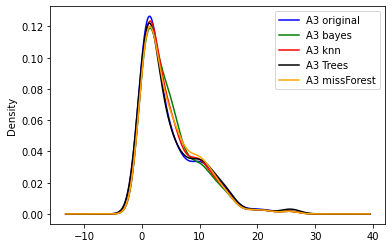

In [74]:
fig = plt.figure()
ax = fig.add_subplot(111)

X_train['A3'].plot(kind='kde', ax=ax, color='blue')
X_train_bayes['A3'].plot(kind='kde', ax=ax, color='green')
X_train_knn['A3'].plot(kind='kde', ax=ax, color='red')
X_train_nonLin['A3'].plot(kind='kde', ax=ax, color='black')
X_train_missForest['A3'].plot(kind='kde', ax=ax, color='orange')

# add legends
lines, labels = ax.get_legend_handles_labels()
labels = ['A3 original', 'A3 bayes', 'A3 knn', 'A3 Trees', 'A3 missForest']
ax.legend(lines, labels, loc='best')
plt.show()

Dans le graphique précédent, nous pouvons voir que les différents algorithmes renvoient des distributions légèrement différentes de la variable d'origine